<a href="https://colab.research.google.com/github/bharathraj-v/geoml-wd/blob/main/notebooks/resnet34%2Bunet_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and preparing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!cp /content/drive/MyDrive/PV01.zip /content/
!unzip PV01.zip

In [3]:
import os
import numpy as np

In [4]:
brick = "PV01/PV01_Rooftop_Brick"
flatConcrete = "PV01/PV01_Rooftop_FlatConcrete"
steelTile = "PV01/PV01_Rooftop_SteelTile"



brick_paths = []
flatConcrete_paths = []
steelTile_paths = []

for root, dirs, files in os.walk(brick):
    for file in files:
        brick_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(flatConcrete):
    for file in files:
        flatConcrete_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(steelTile):
    for file in files:
        steelTile_paths.append(os.path.join(root, file))
     
brick_paths.sort()
flatConcrete_paths.sort()
steelTile_paths.sort()

brick_img, brick_label = [brick_paths[i] for i in range(0,len(brick_paths),2)], [brick_paths[i] for i in range(1,len(brick_paths),2)]
flatConcrete_img, flatConcrete_label = [flatConcrete_paths[i] for i in range(0,len(flatConcrete_paths),2)], [flatConcrete_paths[i] for i in range(1,len(flatConcrete_paths),2)]
steelTile_img, steelTile_label = [steelTile_paths[i] for i in range(0,len(steelTile_paths),2)], [steelTile_paths[i] for i in range(1,len(steelTile_paths),2)]

images = np.concatenate((brick_img, flatConcrete_img, steelTile_img))
masks = np.concatenate((brick_label,flatConcrete_label,steelTile_label  ))

In [5]:
!pip install -q addict
!pip install -q segmentation-models-pytorch
!pip install albumentations==0.4.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=dd51407185839325a9338dbf9ef2997253b3f885a1e24ab870089f29fc6eceef
  Stored in directory: /root/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installat

In [6]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=9265af5c8713e2155dab3932d2fd47d7bcf236711d7878c09e0f8b3710e76b0b
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
from tqdm import tqdm
import os
import logging
import numpy as np
import wandb
from addict import Dict
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore")
logging.basicConfig(format="[%(asctime)s][%(levelname)s] - %(message)s")


In [36]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.disabled = True
logging.getLogger('PIL').setLevel(logging.WARNING)
logging.getLogger('matplotlib.axes._base').setLevel(logging.WARNING)

In [9]:
config = Dict({
    "images_path": "./content/PV01",
})

train_config = Dict({
    "project": "Panel Semantic Segmentation",
    "output_path": "model.onnx",
    "batch_size": 16,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 10,
    
    "model": {
        "type": "UNet",
        "parameters": {
            "encoder_name": "resnet34",
            "in_channels": 3,
        }
    },
    
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.01,
        }
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
        }
    },
    
    "input_size": (256, 256),
    "augmentations": A.Compose([
                                A.Downscale(scale_min=0.5, scale_max=0.75, p=0.2),
                                A.HorizontalFlip(p=0.5),
                                A.Blur(p=0.2),
                                A.VerticalFlip(p=0.5),
                                A.RandomFog(p=0.2),
                                A.RandomBrightness(p=0.2),
                                A.RandomBrightnessContrast(p=1), 
                                A.RandomGamma(p=0.7),
                                ToTensor(),
    ]),
    "num_workers": 4,
})


In [10]:
def train_test_split(dataset, test_size=0.2):
    length = len(dataset)
    train_length = round(length * (1 - test_size))
    test_length = length - train_length
    
    train_dataset, test_dataset = random_split(dataset, [train_length, test_length])
    return train_dataset, test_dataset

In [11]:
%%capture
!cp /content/drive/MyDrive/PV01_pngs.zip /content/
!unzip PV01_pngs.zip

In [12]:
class PanelDataset(Dataset):
    def __init__(self, path, augmentations=None, size=(256, 256)):
        self.__images_masks = []
        self.__size = size
        self.__augmentations = augmentations
        if os.path.exists(path):
            self.__path = path
            self.imgs = list(sorted(os.listdir(os.path.join(path, "images")), key=lambda x: int(x.split("/")[-1].split(".")[0])))
            self.masks = list(sorted(os.listdir(os.path.join(path, "masks")), key=lambda x: int(x.split("/")[-1].split(".")[0])))
            for i in range(len(self.imgs)):
              self.__images_masks.append((self.imgs[i], self.masks[i]))
        else:
            logging.error(f"Path '{path}' doesn't exists")
                    
                
    def __len__(self):
        return len(self.__images_masks)
    
    def load_image(self, path, channels="RGB"):
        width, height = self.__size
        loader = A.Compose([
            A.Resize(width=width, height=height),
        ])
        
        image = np.array(Image.open(path).convert(channels))
        return loader(image=image)["image"]
    
    def __getitem__(self, index):
        if index <= len(self.__images_masks):
            image_path, mask_path = self.__images_masks[index]
            image_path = os.path.join(self.__path, "images", image_path)
            mask_path = os.path.join(self.__path, "masks", mask_path)
            image = self.load_image(image_path)
            mask = self.load_image(mask_path, channels="L")
            if self.__augmentations is not None:
                augmentated = self.__augmentations(image=image, mask=mask)
                return Dict(augmentated)
            
            return Dict({
                "image": image,
                "mask": mask,
            })

In [13]:
dataset = PanelDataset(path="/content",
                      augmentations=train_config.augmentations,
                      size=train_config.input_size)

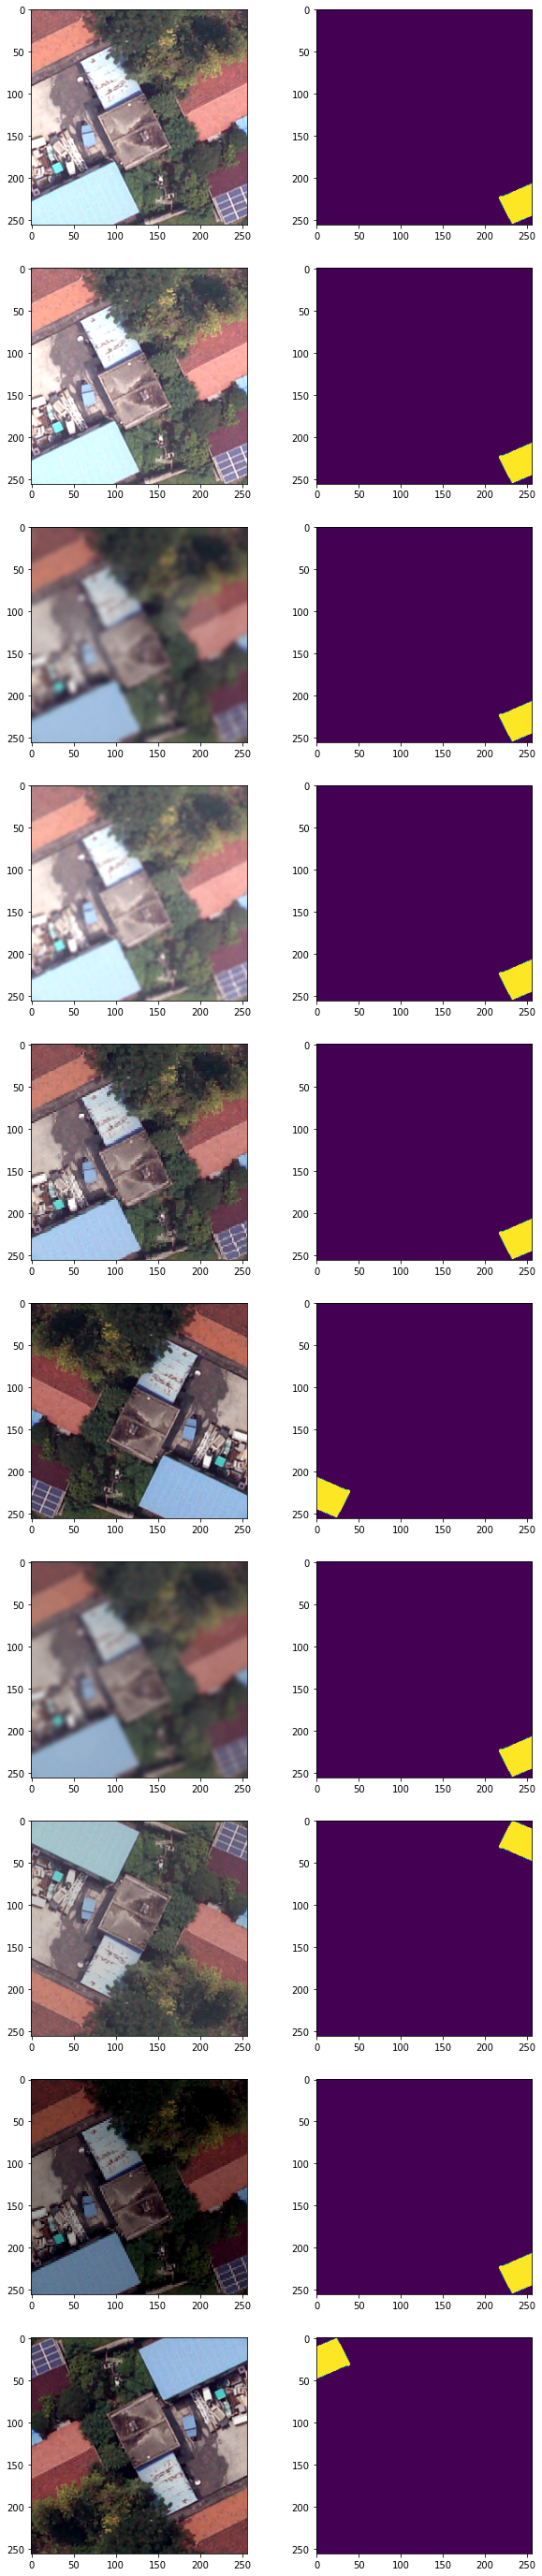

In [21]:
fig, axes = plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    item = dataset[0]
    axes[i, 0].imshow(item.image.permute(1, 2, 0).numpy().reshape(256, 256, 3))
    axes[i, 1].imshow(item.mask.numpy().reshape(256, 256))

In [22]:
train_dataset, test_dataset = train_test_split(dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False)

In [23]:
class Trainer:
    def __init__(self, model, criterion, optimizer, project, output_path, scheduler=None, config={}, device="cpu"):
        self.__model = model
        self.__criterion = criterion
        self.__optimizer = optimizer
        self.__scheduler = scheduler,
        self.__project = project
        self.__device = device
        self.__output_path = output_path
        self.__config = config
        
    def evaluate(self, loader):
        self.__model.to(self.__device)
        loader_length = len(loader)
        loss = 0
        with torch.no_grad():
            for batch in loader:
                torch.cuda.empty_cache()
                
                images = batch["image"].to(self.__device)
                masks = batch["mask"].cpu()
                
                outputs = model(images).cpu()
                batch_loss = self.__criterion(outputs, masks)
                loss += batch_loss.item()
            
        loss /= loader_length
        return loss
    
    def fit(self, loader, validation_loader=None, epochs=10):
        with wandb.init(project=self.__project, config=self.__config):
            wandb.watch(self.__model, self.__criterion, log="all")
            self.__model.to(self.__device)
            loader_length = len(loader)
            for epoch in range(epochs):
                loop = tqdm(loader)
                loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                epoch_loss = 0
                for batch in loop:
                    torch.cuda.empty_cache()
                    self.__optimizer.zero_grad()

                    images = batch["image"].to(self.__device)
                    masks = batch["mask"].cpu()

                    outputs = self.__model(images).cpu()
                    batch_loss = self.__criterion(outputs, masks)

                    epoch_loss += batch_loss.item()
                    loop.set_postfix(loss=batch_loss.item())

                    batch_loss.backward()
                    self.__optimizer.step()



                epoch_loss /= loader_length
                loop.set_postfix(loss=epoch_loss)
                wandb.log({"loss": epoch_loss}, step=epoch+1)

                if validation_loader is not None:
                    validation_loss = self.evaluate(validation_loader)
                    loop.set_postfix(validation_loss=validation_loss)
                    wandb.log({"validation_loss": validation_loss}, step=epoch+1)

                    if self.__scheduler is not None:
                        scheduler.step(validation_loss)
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                else:
                    if self.__scheduler is not None:
                        scheduler.step()
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                        
            torch.onnx.export(model, images, self.__output_path)
            wandb.save(self.__output_path)

In [24]:
if train_config.model.type == "UNet":
    model = smp.Unet(**train_config.model.parameters)
    
criterion = nn.BCEWithLogitsLoss()

if train_config.optimizer.type == "AdamW":
    optimizer = AdamW(model.parameters(), **train_config.optimizer.parameters)
    
    
if "scheduler" in train_config:
    if train_config.scheduler.type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, **train_config.scheduler.parameters)
else:
    scheduler = None
    
trainer = Trainer(model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  device=train_config.device,
                  project=train_config.project,
                  output_path=train_config.output_path,
                  config=train_config)

In [26]:
trainer.fit(loader=train_loader, validation_loader=test_loader, epochs=train_config.epochs)

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 172.28.0.2:9000
DEBUG:urllib3.connectionpool:http://172.28.0.2:9000 "GET /api/sessions?token= HTTP/1.1" 200 442


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
DEBUG:git.util:Failed checking if running in CYGWIN due to: FileNotFoundError(2, 'No such file or directory')


Epoch [5/10]:   0%|          | 0/33 [00:00<?, ?it/s]DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): o151352.ingest.sentry.io:443
DEBUG:urllib3.connectionpool:https://o151352.ingest.sentry.io:443 "POST /api/5288891/envelope/ HTTP/1.1" 200 2
Epoch [10/10]: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s, loss=0.328]


loss,█▃▄▄▃▃▂▂▂▁
lr,█████▂▂▂▁▁
validation_loss,▅█▁▄▇▃▄▅▅▄
loss,0.35482
lr,0.0001
validation_loss,0.68033


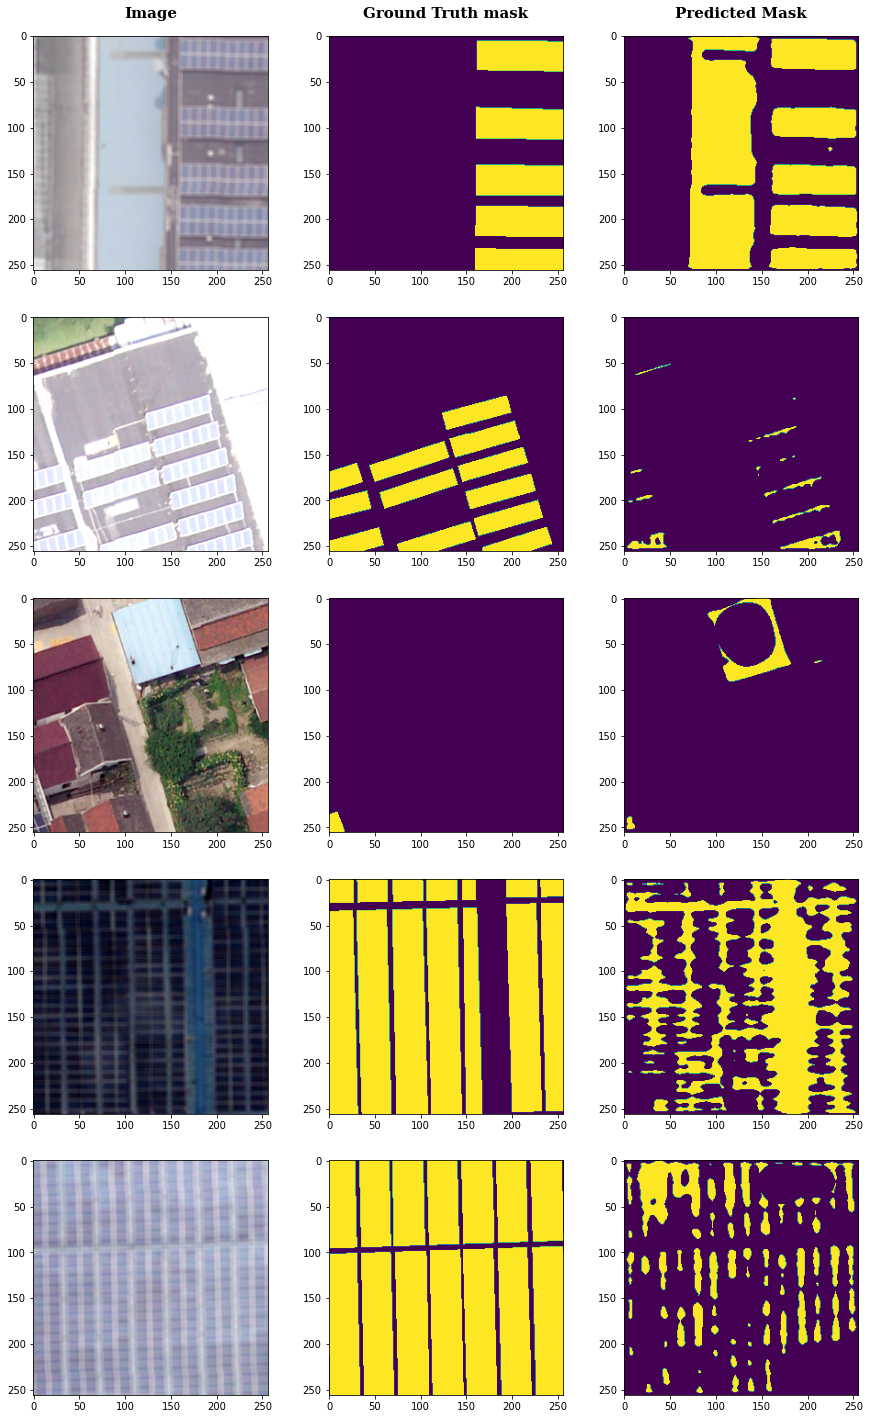

In [37]:
model.to(train_config.device)

test_length = len(test_loader)

fig, axes = plt.subplots(test_length, 3, figsize=(3*5, test_length * 5))
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        torch.cuda.empty_cache()
                
        images = batch["image"].to(train_config.device)
        masks = batch["mask"].cpu()
                
        outputs = model(images).cpu()
        
        image, mask, predicted_mask = images.cpu()[0].permute(1, 2, 0).numpy(), masks[0].permute(1, 2, 0).numpy().reshape(256, 256), outputs[0].permute(1, 2, 0).numpy().reshape(256, 256)
        binary_predicted_mask = np.where(predicted_mask > 0.2, 1, 0)
        
        image_ax, mask_ax, predicted_mask_ax = axes[idx, 0], axes[idx, 1], axes[idx, 2]
        
        image_ax.imshow(image)
        mask_ax.imshow(mask)
        predicted_mask_ax.imshow(binary_predicted_mask)
        
        
        if idx == 0:
            image_ax.set_title("Image", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            mask_ax.set_title("Ground Truth mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            predicted_mask_ax.set_title("Predicted Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
        
fig.show()

In [38]:
trainer.fit(loader=train_loader, validation_loader=test_loader, epochs=100)

wandb: Currently logged in as: bharathrajpalivela. Use `wandb login --relogin` to force relogin


Epoch [100/100]: 100%|██████████| 33/33 [00:09<00:00,  3.49it/s, loss=0.323]


loss,▅▃▄▄▂▅▂▂▇▃▄▃▅▃▄▂▃▂▁█▄▅▅▃▃▅▃▃▆▃▅▁▃█▃▃▃▂▂▃
lr,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▇▃▃▃▆▃▅▂▁▅▆▄▃▃▄▃▃▆▆▄▇▃▄▆▄▄▄▄▄▄▄▃▆▅▅▅▅█▄
loss,0.35881
lr,0.0
validation_loss,0.68819


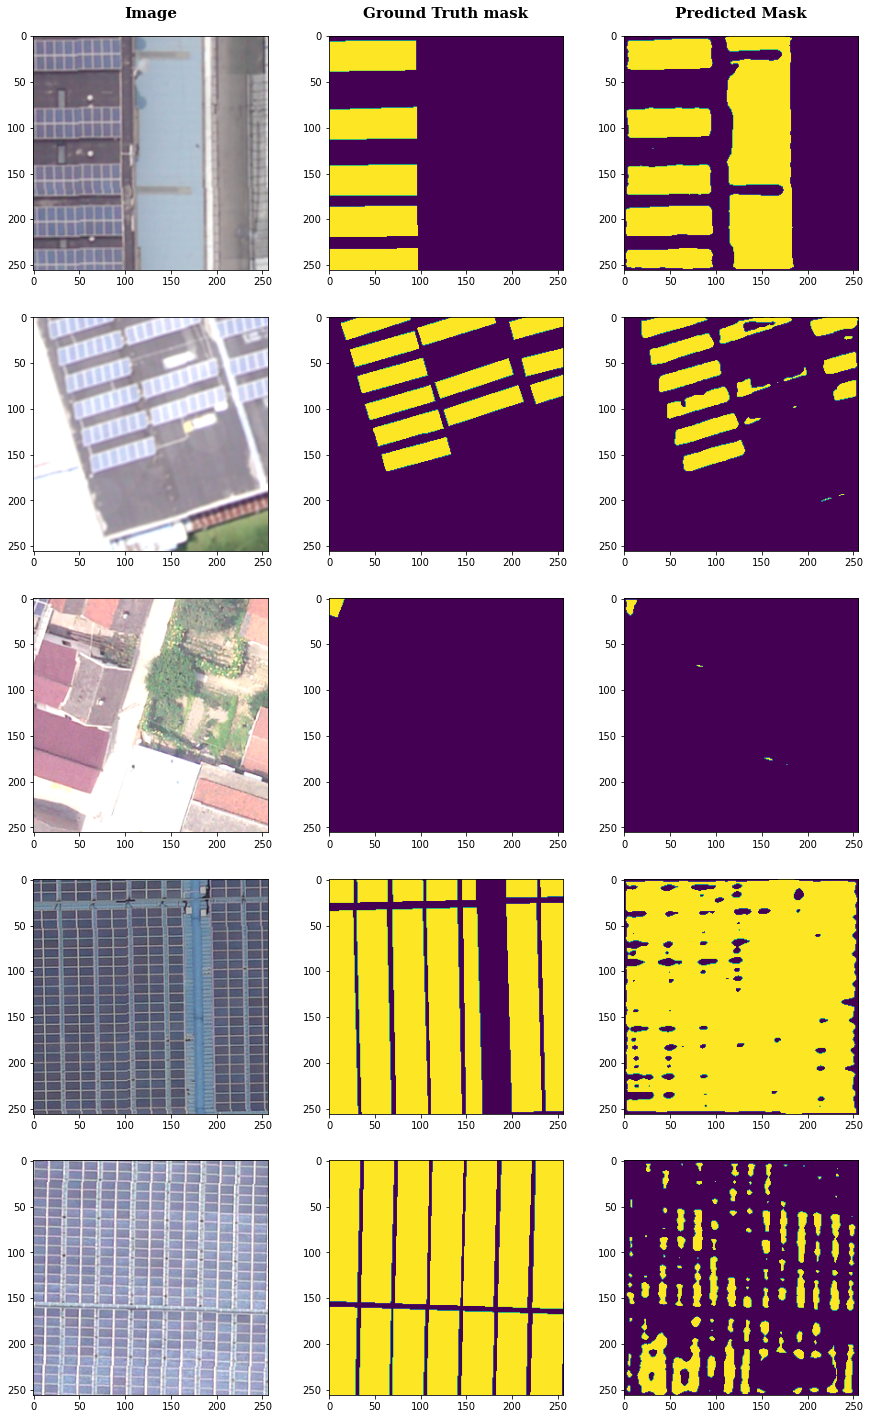

In [39]:
model.to(train_config.device)

test_length = len(test_loader)

fig, axes = plt.subplots(test_length, 3, figsize=(3*5, test_length * 5))
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        torch.cuda.empty_cache()
                
        images = batch["image"].to(train_config.device)
        masks = batch["mask"].cpu()
                
        outputs = model(images).cpu()
        
        image, mask, predicted_mask = images.cpu()[0].permute(1, 2, 0).numpy(), masks[0].permute(1, 2, 0).numpy().reshape(256, 256), outputs[0].permute(1, 2, 0).numpy().reshape(256, 256)
        binary_predicted_mask = np.where(predicted_mask > 0.2, 1, 0)
        
        image_ax, mask_ax, predicted_mask_ax = axes[idx, 0], axes[idx, 1], axes[idx, 2]
        
        image_ax.imshow(image)
        mask_ax.imshow(mask)
        predicted_mask_ax.imshow(binary_predicted_mask)
        
        
        if idx == 0:
            image_ax.set_title("Image", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            mask_ax.set_title("Ground Truth mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
            predicted_mask_ax.set_title("Predicted Mask", fontsize=15, fontweight="bold", fontfamily="serif", y=1.05)
        
        
fig.show()